### Preliminaries

In [1]:
# Preliminaries to setup the notebook.  
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Import the file I wrote to load the data from the tab-delimited text files.  
import dream
import loading
import scoring
import fit1

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
#여기서 training 은 train_set 데이터를 가리킨다. 따라서 perceptual data는 train_set의 데이터값들을 나타낸다. 
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
#dream.NUM_DESCRIPTORS가 무엇인지 도저히 모르겠다. 알아보자.
#assert는 조건문 으로써 assert다음에 오는 문장이 참이 아님면 밑으로 실행이 되지 않는다. 
assert num_descriptors == dream.NUM_DESCRIPTORS
num_subjects = dream.NUM_SUBJECTS
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [6]:
# Load the molecular descriptors data.  
#아래의 코드는 molecular_descriptors_data.txt텍스트를 여는 코드이다. 
molecular_headers, molecular_data = loading.load_molecular_data()
#feature(x)의 개수 4870
#y의 개수 476
print(len(molecular_headers)) 
print(len(molecular_data))
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

4870
476
First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
#정확하게 len(perceptual_obs_data) 는 총 데이터의 수 
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


### Create Molecular Matrix

In [8]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
#perceptual_data에서 하나씩 뽑아와서 row
print(set([int(row[0]) for row in perceptual_obs_data]))
#위의 코드는 len(set([int(row[0]) for row in perceptual_obs_data]))의 결과가 어떻게 되는지 보려고 삽입함. 좀더 알아보자. row[0]이 이해안됨
print(training_size)
#training_size의 크기 보려고 입력함 위에서 처럼 set으로 받으면 중복 없애 주어서 실험용 분자의 개수를 알 수 있다.

print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

{8193, 6658, 31234, 220674, 1032, 8712, 12297, 12810, 31244, 12813, 31246, 7695, 31249, 85522, 8723, 15380, 31252, 521238, 1049, 7194, 98330, 31260, 31265, 31268, 4133, 12327, 6184, 7720, 9256, 31272, 1068, 9261, 10285, 10797, 444972, 5364729, 7731, 24116, 638014, 21057, 6213, 7749, 60999, 61005, 78925, 7761, 7762, 8785, 7765, 1110, 61527, 7768, 23642, 8797, 6753, 5363388, 61027, 520296, 5362798, 1136, 7795, 62580, 17525, 7799, 7288, 61048, 18554, 7803, 10364, 61052, 126, 11902, 444539, 637563, 10882, 637566, 6276, 24197, 9862, 62087, 440967, 650, 10890, 6287, 7824, 10895, 21648, 5779, 660, 5780, 15510, 101010, 6429333, 8857, 14491, 1183, 10400, 11428, 2214, 7335, 8363, 31404, 7341, 10925, 176, 177, 14514, 3578033, 8375, 8892, 14525, 10430, 15037, 3776, 7360, 7361, 23235, 196, 62144, 2758, 93375, 5280450, 61641, 61130, 18635, 8908, 11980, 10448, 17617, 8914, 61138, 61653, 7894, 8918, 12506, 26331, 61659, 17121, 1549026, 101604, 6374, 61670, 7915, 7916, 643820, 239, 240, 241, 7410, 7921

In [9]:
import pandas as pd
#import sys
#위의 sys는 필요 없어서 지움
#밑의 print들은 원하는대로 바뀌었는지 검사하는 과정

In [10]:
X_training,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"training")
#dream.make_X해석하기, 특히 assert kind in ['training','leaderboard','testset']이게 뭔지 알기. <-알아서 설명 적어둠
X_training.shape
#if type("training") is str:
    #training = ["training"]
#rint(type(training))
#print("training")
#print(training)

#밑의 코드는 위의 결과를 csv파일로 저장하는 과정이다. 
df_X_training = pd.DataFrame(data = X_training)
df_X_training.to_csv('결과1/X_training.csv')

df_X_training_good1 = pd.DataFrame(data = good1)
df_X_training_good1.to_csv('결과1/X_training_good1.csv')

df_X_training_good2 = pd.DataFrame(data = good2)
df_X_training_good2.to_csv('결과1/X_training_good2.csv')

df_X_training_means = pd.DataFrame(data = means)
df_X_training_means.to_csv('결과1/X_training_means.csv')

df_X_training_stds = pd.DataFrame(data = stds)
df_X_training_stds.to_csv('결과1/X_training_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 676 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (676x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (676x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (676x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (676x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors


In [11]:
print(df_X_training)
#X_training
#결과는 잘 나왔다. 

         0         1         2         3         4         5         6     \
0   -0.097027 -0.453737  0.581957 -0.638775 -0.920075 -0.810565 -0.998679   
1   -0.097027 -0.453737  0.581957 -0.638775 -0.920075 -0.810565 -0.998679   
2   -1.380812 -2.303775  0.360150 -2.486655 -2.205301 -2.673468 -2.213874   
3   -1.380812 -2.303775  0.360150 -2.486655 -2.205301 -2.673468 -2.213874   
4   -2.272064 -2.983815 -0.102210 -2.825315 -2.529353 -2.879935 -2.469563   
..        ...       ...       ...       ...       ...       ...       ...   
671  0.500907  0.575051 -0.360776  0.724985  0.831187  0.752246  0.844477   
672  0.645542  0.088929  0.158888  0.153410 -0.160561  0.099693 -0.194121   
673  0.645542  0.088929  0.158888  0.153410 -0.160561  0.099693 -0.194121   
674  0.018099  0.089142 -0.184785  0.040156  0.250776 -0.015968  0.244074   
675  0.018099  0.089142 -0.184785  0.040156  0.250776 -0.015968  0.244074   

         7         8         9     ...      3023      3024      3025  \
0  

In [12]:
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_other.shape
#print(X_leaderboard_other)

#print(means)

#print(imputer)

df_X_leaderboard_other = pd.DataFrame(data = X_leaderboard_other)
df_X_leaderboard_other.to_csv('결과1/X_leaderboard_other.csv')

df_X_leaderboard_other_good1 = pd.DataFrame(data = good1)
df_X_leaderboard_other_good1.to_csv('결과1/X_leaderboard_other_good1.csv')

df_X_leaderboard_other_good2 = pd.DataFrame(data = good2)
df_X_leaderboard_other_good2.to_csv('결과1/X_leaderboard_other_good2.csv')

df_X_leaderboard_other_means = pd.DataFrame(data = means)
df_X_leaderboard_other_means.to_csv('결과1/X_leaderboard_other_means.csv')

df_X_leaderboard_other_stds = pd.DataFrame(data = stds)
df_X_leaderboard_other_stds.to_csv('결과1/X_leaderboard_other_stds.csv')

#sys.stdout = open('결과1/X_leaderboard_other.txt', 'w')
#print(X_leaderboard_other)

#일단 이거 살피다가 데이터 전처리 하는것은 넘어가고 빠르게 결과로 가자.

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [13]:
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int.shape

df_X_leaderboard_int = pd.DataFrame(data = X_leaderboard_int)
df_X_leaderboard_int.to_csv('결과1/X_leaderboard_int.csv')

df_X_leaderboard_int_good1 = pd.DataFrame(data = good1)
df_X_leaderboard_int_good1.to_csv('결과1/X_leaderboard_int_good1.csv')

df_X_leaderboard_int_good2 = pd.DataFrame(data = good2)
df_X_leaderboard_int_good2.to_csv('결과1/X_leaderboard_int_good2.csv')

df_X_leaderboard_int_means = pd.DataFrame(data = means)
df_X_leaderboard_int_means.to_csv('결과1/X_leaderboard_int_means.csv')

df_X_leaderboard_int_stds = pd.DataFrame(data = stds)
df_X_leaderboard_int_stds.to_csv('결과1/X_leaderboard_int_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [14]:
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_other.shape

df_X_testset_other = pd.DataFrame(data = X_testset_other)
df_X_testset_other.to_csv('결과1/X_testset_other.csv')

df_X_testset_other_good1 = pd.DataFrame(data = good1)
df_X_testset_other_good1.to_csv('결과1/X_testset_other_good1.csv')

df_X_testset_other_good2 = pd.DataFrame(data = good2)
df_X_testset_other_good2.to_csv('결과1/X_testset_other_good2.csv')

df_X_testset_other_means = pd.DataFrame(data = means)
df_X_testset_other_means.to_csv('결과1/X_testset_other_means.csv')

df_X_testset_other_stds = pd.DataFrame(data = stds)
df_X_testset_other_stds.to_csv('결과1/X_testset_other_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [15]:
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_int.shape

df_X_testset_int = pd.DataFrame(data = X_testset_int)
df_X_testset_int.to_csv('결과1/X_testset_int.csv')

df_X_testset_int_good1 = pd.DataFrame(data = good1)
df_X_testset_int_good1.to_csv('결과1/X_testset_int_good1.csv')

df_X_testset_int_good2 = pd.DataFrame(data = good2)
df_X_testset_int_good2.to_csv('결과1/X_testset_int_good2.csv')

df_X_testset_int_means = pd.DataFrame(data = means)
df_X_testset_int_means.to_csv('결과1/X_testset_int_means.csv')

df_X_testset_int_stds = pd.DataFrame(data = stds)
df_X_testset_int_stds.to_csv('결과1/X_testset_int_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [16]:
X_all,good1,good2,means,stds,imputer = dream.make_X(molecular_data,["training","leaderboard"],good1=good1,good2=good2,means=means,stds=stds)
X_all.shape


df_X_all = pd.DataFrame(data = X_all)
df_X_all.to_csv('결과1/X_all.csv')

df_X_all_good1 = pd.DataFrame(data = good1)
df_X_all_good1.to_csv('결과1/X_all_good1.csv')

df_X_all_good2 = pd.DataFrame(data = good2)
df_X_all_good2.to_csv('결과1/X_all_good2.csv')

df_X_all_means = pd.DataFrame(data = means)
df_X_all_means.to_csv('결과1/X_all_means.csv')

df_X_all_stds = pd.DataFrame(data = stds)
df_X_all_stds.to_csv('결과1/X_all_stds.csv')

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (814x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (814x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (814x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (814x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors


In [17]:
Y_training,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')

#df_Y_training_subject = pd.DataFrame(data = Y_training['subject'])
#df_Y_training_subject.to_csv('결과1/Y_training_subject.csv')

#df_Y_training_mean_std = pd.DataFrame(data = Y_training['mean_std'])
#df_Y_training_mean_std.to_csv('결과1/Y_training_means_std.csv')


Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [18]:
Y_training.keys()

dict_keys(['subject', 'mean_std'])

In [19]:
type(Y_training['subject'])
#y의 출력결과도 알기 위해서 type을 알아봄. 

dict

In [20]:
Y_training['subject'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [21]:
type(Y_training['subject'][1])

numpy.ma.core.MaskedArray

In [22]:
#한사람이 몇개 검사했는지 데이터 보기 위해서 따로 하나 뽑음

df_Y_training_subject_1 = pd.DataFrame(data = Y_training['subject'][1])

In [23]:
df_Y_training_subject_1.to_csv('결과1/Y_training_subject_1.csv')

In [24]:
#range(2,50) 2~49까지 for문 돌린다. 
for i in range(1, 50):
    df_Y_training_subject = pd.DataFrame(data = Y_training['subject'][i])
    df_Y_training_subject.to_csv('결과1/Y_training_subject.csv')

##이렇게 하면 한 파일에 다 저장이 되는데 어떻게 하면 48개의 파일로 만들 수 있을지 생각해보기.

In [25]:
type(Y_training['mean_std'])

numpy.ndarray

In [26]:
Y_training['mean_std']

array([[24.65306122, 51.05882353,  0.41176471, ...,  4.92349559,
        14.12498915, 18.87043024],
       [49.55102041, 48.95652174,  0.63043478, ...,  6.35156605,
        22.14199891, 21.47108985],
       [ 4.55102041, 47.25      ,  0.5625    , ...,  7.40178751,
        10.87374274, 15.80739377],
       ...,
       [12.85714286, 36.5483871 ,  1.35483871, ..., 12.34315578,
        20.18113539, 23.60691192],
       [17.83673469, 45.28571429,  3.9047619 , ...,  7.18795288,
        13.90835937, 14.4307322 ],
       [45.14285714, 51.19047619, 13.66666667, ...,  7.45093075,
        13.60462471, 22.31703608]])

In [27]:
df_Y_training_mean_std = pd.DataFrame(data = Y_training['mean_std'])
df_Y_training_mean_std.to_csv('결과1/Y_training_means_std.csv')

In [28]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Y_leaderboard.keys()

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

dict_keys(['subject', 'mean_std'])

In [29]:
for i in range(1, 50):
    df_Y_leaderboard_subject = pd.DataFrame(data = Y_leaderboard['subject'][i])
    df_Y_leaderboard_subject.to_csv('결과1/Y_leaderboard_subject.csv')

In [30]:
df_Y_leaderboard_mean_std = pd.DataFrame(data = Y_leaderboard['mean_std'])
df_Y_leaderboard_mean_std.to_csv('결과1/Y_leaderboard_means_std.csv')

In [31]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

for i in range(1, 50):
    df_Y_all_imp_subject = pd.DataFrame(data = Y_all_imp['subject'][i])
    df_Y_all_imp_subject.to_csv('결과1/Y_all_imp_subject.csv')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [32]:
df_Y_all_imp_mean_std = pd.DataFrame(data = Y_all_imp['mean_std'])
df_Y_all_imp_mean_std.to_csv('결과1/Y_all_imp_means_std.csv')

### Data preparation

Text(0.5, 0, 'Perceptual descriptor values')

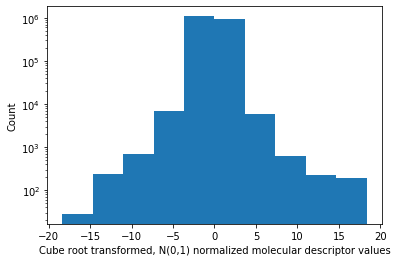

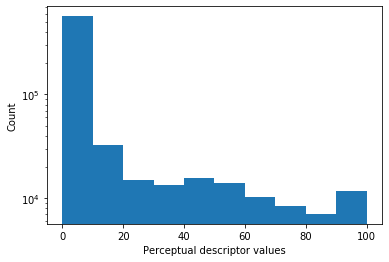

In [33]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(np.dstack([Y_training['subject'][subject] for subject in range(1,50)]).ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Perceptual descriptor values')

## Fitting and Generating Submission Files

In [34]:
#한번 write를 true로 바꾸어 보도록 하자. 
write = True # Set to True to actually generate the prediction files.  
#write = False
n_estimators = 5 # Set this to a high number (e.g. 100) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':None,
                'ple':100,
                'dec':500}
min_samples_leaf = {'int':1,
                'ple':1,
                'dec':1}
max_depth = {'int':None,
                'ple':10,
                'dec':10}
et = {'int':True,
      'ple':False,
      'dec':False,}

In [35]:
# Fit training data.  
rfcs_leaderboard,score,rs = fit1.rfc_final(X_training,Y_training['subject'],
                            max_features,min_samples_leaf,max_depth,et,
                            n_estimators=n_estimators)

#df_rfcs_leaderboard = pd.DataFrame(data = rfcs)
#df_rfcs_leaderboard.to_csv('결과1/rfcs_leaderboard.csv')

#밑의 코드를 실행하면 DataFrame constructor not properly called!의 오류가 뜬다. 
#df_rfcs_leaderboard_score = pd.DataFrame(data = score)
#df_rfcs_leaderboard_score.to_csv('결과1/rfcs_leaderboard_score.csv')

#df_rfcs_leaderboard_rs= pd.DataFrame(data = rs)
#df_rfcs_leaderboard_rs.to_csv('결과1/rfcs_leaderboard_rs.csv')



/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

For subchallenge 1:
	Score = 27.27
	int = 0.887
	ple = 0.141
	dec = 0.111


In [36]:
#밑의 과정들은 저장을 위해서 결과의 data tpye들을 알아보는 중이다. 
type(rfcs_leaderboard)

dict

In [37]:
rfcs_leaderboard.keys()

dict_keys(['int', 'ple', 'dec'])

In [38]:
df_rfcs_leaderboard = pd.DataFrame(data = rfcs_leaderboard)
df_rfcs_leaderboard.to_csv('결과1/rfcs_leaderboard.csv')
rfcs_leaderboard

{'int': {1: ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=-1, oob_score=False, random_state=0,
                      verbose=0, warm_start=False),
  2: ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=-1, oob_score=False, random_state=0,
                      verbose=0, warm_start=False),
  3: Ex

In [39]:
type(score)

numpy.float64

In [40]:
type(rs)

dict

In [41]:
rs

{'int': 0.8865399027875027,
 'ple': 0.14068000604003744,
 'dec': 0.11088710246673102}

In [42]:
_ = loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,'leaderboard',1,Y_test=Y_leaderboard,write=write)
print(_['subject'][1]) # Print values for subject 1 to make sure it looks right.  

#df_rfcs_leaderboard_predictionresult = pd.DataFrame(data = _)
#df_rfcs_leaderboard.to_csv('결과1/rfcs_leaderboard.csv')


/Users/kimjaehee/Desktop/git/dream-master practice/scoring.py:103: UserWarning: Warning: converting a masked element to nan.
  if ('%f' % r_) == 'nan':


Score: 9.856691; rs = 0.434,0.029,0.020
Wrote to file with suffix "1583821099"
[[67.74       45.53485926 11.38694673 ...  1.3139134   3.64005314
  16.30871753]
 [64.04       47.1324885   1.33120084 ...  2.77306025  4.29559165
  21.32311689]
 [37.12285714 34.38721598  2.43839143 ...  2.00697227  2.37423025
  11.38369428]
 ...
 [27.21428571 48.51978481  1.66148507 ...  2.81808713  5.63339503
   9.04406456]
 [52.84857143 40.75642332  2.11523345 ...  2.09871171  6.20992644
  15.88222253]
 [46.59142857 46.1390201   2.12696753 ...  3.41152515  6.13856617
  12.15222307]]


In [43]:
_

{'subject': {1: array([[67.74      , 45.53485926, 11.38694673, ...,  1.3139134 ,
           3.64005314, 16.30871753],
         [64.04      , 47.1324885 ,  1.33120084, ...,  2.77306025,
           4.29559165, 21.32311689],
         [37.12285714, 34.38721598,  2.43839143, ...,  2.00697227,
           2.37423025, 11.38369428],
         ...,
         [27.21428571, 48.51978481,  1.66148507, ...,  2.81808713,
           5.63339503,  9.04406456],
         [52.84857143, 40.75642332,  2.11523345, ...,  2.09871171,
           6.20992644, 15.88222253],
         [46.59142857, 46.1390201 ,  2.12696753, ...,  3.41152515,
           6.13856617, 12.15222307]]),
  2: array([[67.08      , 46.93771599,  3.88408271, ...,  1.42137776,
           3.95226188, 19.08263383],
         [67.94      , 49.41407982,  1.37075356, ...,  3.45456862,
           4.88936661, 14.74113049],
         [44.92285714, 36.62494997,  2.51082138, ...,  2.1350915 ,
           2.59358259,  9.09961521],
         ...,
         [28.2942

In [44]:
type(_)

dict

In [45]:
_.keys()

dict_keys(['subject'])

In [46]:
df_rfcs_leaderboard_predictionresult = pd.DataFrame(data = _)
df_rfcs_leaderboard_predictionresult.to_csv('결과1/rfcs_leaderboard_predictionresult.csv')

In [47]:
rfcs,score,rs = fit1.rfc_final(X_all,Y_all_imp['subject'],
                            max_features,min_samples_leaf,max_depth,et,
                            n_estimators=n_estimators)

df_rfcs = pd.DataFrame(data = rfcs)
df_rfcs.to_csv('결과1/rfcs.csv')

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kimjaehee/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means t

For subchallenge 1:
	Score = 28.05
	int = 0.886
	ple = 0.150
	dec = 0.119


In [48]:
_ = loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',1,write=False)
print(_['subject'][1]) # Print values for subject 1 to make sure it looks right. 

df_rfcs_predictionresult = pd.DataFrame(data = _)
df_rfcs_predictionresult.to_csv('결과1/rfcs_predictionresult.csv')

[[17.51142857 45.45103048  1.82887743 ...  3.16909256  3.13712229
  14.25814411]
 [22.73714286 41.30419574  2.14069816 ...  2.24551212  3.56814451
  17.038831  ]
 [49.44       39.74036856  1.85292398 ...  1.73408968  3.57986147
   8.61641725]
 ...
 [54.96857143 45.8025428   2.57607782 ...  4.6392501   5.7437693
   9.3322232 ]
 [23.56285714 49.36120199  2.8558064  ...  3.45734144  5.51156672
   9.97267811]
 [48.05714286 45.46695469  1.93624672 ...  3.13132904 12.1112818
  13.70763939]]
